# Integrantes:  
Gaston Arida, Sebastian Ferreiro, Jeronimo Vernay

---

Nota: Los archivos originales fueron modificados para facilitar la lectura de los mismos. Aquí se encuentran
    en formato csv, y con pequeños cambios como nombres de columnas que no afectan a la información 
    concreta de los archivos originales.

---

# Leemos los archivos originales:

In [ ]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

BP = pd.read_csv("TablasModelo\\BP_limpio.csv")                          
EE = pd.read_csv("TablasModelo\\EE_limpio.csv", dtype={'id_departamento': str})
Provincia = pd.read_csv("TablasModelo\\Provincia.csv")
Depto = pd.read_csv("TablasModelo\\Departamento.csv")
Poblacion = pd.read_csv("TablasModelo\\Padron_limpio.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'TablasModelo\\depto.csv'

In [6]:
query = """
SELECT DISTINCT
    id_departamento,
    departamento,
    SUBSTR(CAST(id_departamento AS VARCHAR), 1, 2) AS id_provincia
FROM EE
"""

resultado = duckdb.query(query).df()

# Guardar a CSV
resultado.to_csv("EE_con_departamento.csv", index=False)

---

# Consultas SQL en base al modelo relacional:

# Primer consulta

"Para cada departamento informar la provincia, el nombre del departamento,
la cantidad de EE de cada nivel educativo, considerando solamente la
modalidad común, y la cantidad de habitantes por edad según los niveles
educativos. El orden del reporte debe ser alfabético por provincia y dentro de
las provincias, descendente por cantidad de escuelas primarias."

In [8]:
consulta1 = """

-- 1) Contamos los EE por tipo y por departamento
-- Utilizamos Cueanexo como identificador unico de cada Establecimiento 
WITH ee_por_departamento AS (
    SELECT 
        id_departamento,
        COUNT(CASE WHEN Jardin > 0 THEN Cueanexo END) AS jardines,
        COUNT(CASE WHEN Primario > 0 THEN Cueanexo END) AS primarias,
        COUNT(CASE WHEN Secundario > 0 THEN Cueanexo END) AS secundarios
    FROM EE
    GROUP BY id_departamento
),

-- 2) Calculo la poblacion por niveles educativos (por ejem: 3 a 5 es Jardin) con ayuda de la separacion
-- hecha por Rango Etario
poblacion_por_departamento AS (
    SELECT 
        id_departamento,
        SUM(CASE WHEN "Rango etario" = '3 a 5' THEN casos ELSE 0 END) AS poblacion_jardin,
        SUM(CASE WHEN "Rango etario" = '6 a 11' THEN casos ELSE 0 END) AS poblacion_primaria,
        SUM(CASE WHEN "Rango etario" = '12 a 18' THEN casos ELSE 0 END) AS poblacion_secundaria
    FROM Poblacion
    GROUP BY id_departamento
)

-- 3) Consulta que une los datos, como se muestra en la tabla de ejemplo
SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,

    COALESCE(ee.jardines, 0) AS jardines,
    COALESCE(pob.poblacion_jardin, 0) AS poblacion_jardin,

    COALESCE(ee.primarias, 0) AS primarias,
    COALESCE(pob.poblacion_primaria, 0) AS poblacion_primaria,

    COALESCE(ee.secundarios, 0) AS secundarios,
    COALESCE(pob.poblacion_secundaria, 0) AS poblacion_secundaria


-- 4) Indicamos los valores que queremos como generales y hacemos LEFT JOIN para incluir todo
-- Ordenamos como pide el enunciado.
FROM Depto dept
JOIN Provincia prov ON dept.id_provincia = prov.id
LEFT JOIN ee_por_departamento ee ON dept.id_departamento = ee.id_departamento
LEFT JOIN poblacion_por_departamento pob ON dept.id_departamento = pob.id_departamento

ORDER BY prov.nombre ASC, primarias DESC;
"""

resultado1 = duckdb.query(consulta1).to_df()
print(f"resultados 1: {resultado1}")

resultados 1:      provincia    departamento  jardines  poblacion_jardin  primarias  \
0    Catamarca           BELEN        45            1434.0         57   
1    Catamarca          LA PAZ        29            1261.0         51   
2    Catamarca         CAPITAL        51            8055.0         46   
3    Catamarca       TINOGASTA        30            1134.0         39   
4    Catamarca     SANTA MARIA        27            1238.0         33   
..         ...             ...       ...               ...        ...   
404    Tucumán         TRANCAS        25            1163.0         25   
405    Tucumán  TAFI DEL VALLE        22            1010.0         24   
406    Tucumán        FAMAILLA        24            2322.0         23   
407    Tucumán  JUAN B ALBERDI        20            1586.0         19   
408    Tucumán        LA COCHA        17             992.0         18   

     poblacion_primaria  secundarios  poblacion_secundaria  
0                2993.0           27            

# Segunda consulta

"Para cada departamento informar la provincia, el nombre del departamento y
la cantidad de BP fundadas desde 1950. El orden del reporte debe ser
alfabético por provincia y dentro de las provincias, descendente por cantidad de BP de dicha capacidad."

In [22]:
consulta2 = """
SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,
    COUNT(*) AS Cant_BP_fundadas_desde_1950     -- Conteo de las BP's que cumplen condicion


-- Hacemos los JOIN's usando el modelo del enunciado
FROM BP bp
JOIN Departamento dept ON bp.id_departamento = dept.id_departamento
JOIN Provincia prov ON dept.id_provincia = prov.id

-- Como las fechas estan indexadas como año-mes-dia, buscamos solamente los primeros 4 numeros
-- fecha_fundacion es dtype object, por lo que convertimos a los primeros 4 chars en numero y lo comparamos con 1950
-- En SQL la primera posicion es 1, no 0.
WHERE 
    TRY_CAST(SUBSTR(bp.fecha_fundacion, 1, 4) AS INTEGER) >= 1950

-- Agrupamos como pide el enunciado 
GROUP BY prov.nombre, dept.Departamento
ORDER BY prov.nombre ASC, Cant_BP_fundadas_desde_1950 DESC;
"""

resultado2 = duckdb.query(consulta2).to_df()
print(f"resultados 2: {resultado2}")

resultados 2:         provincia    departamento  Cant_BP_fundadas_desde_1950
0    Buenos Aires      LA MATANZA                           15
1    Buenos Aires        LA PLATA                           15
2    Buenos Aires          MORENO                           13
3    Buenos Aires           TIGRE                           12
4    Buenos Aires    BAHIA BLANCA                           12
..            ...             ...                          ...
358       Tucumán      TAFI VIEJO                            1
359       Tucumán       RIO CHICO                            1
360       Tucumán        FAMAILLA                            1
361       Tucumán  TAFI DEL VALLE                            1
362       Tucumán     CHICLIGASTA                            1

[363 rows x 3 columns]


# Tercer consulta

"Para cada departamento, indicar provincia, nombre del departamento,
cantidad de BP, cantidad de EE (de modalidad común) y población total.
Ordenar por cantidad EE descendente, cantidad BP descendente, nombre de 
provincia ascendente y nombre de departamento ascendente. No omitir casos sin BP o EE."

In [23]:
consulta3 = """
-- Creamos las Tablas temporales

-- 1) Contamos las BP unicas por departamento
WITH bp_por_dpto AS (
    SELECT 
        id_departamento,
        COUNT(DISTINCT nro_conabip) AS cantidad_bp      -- Usamos nro_conabip como identificador unico (nuestra PK)
    FROM BP
    GROUP BY id_departamento
),

-- 2) Contamos los EE unico por departamento
ee_por_dpto AS (
    SELECT 
        id_departamento,
        COUNT(DISTINCT Cueanexo) AS cantidad_ee     -- Usamos Cueanexo como identificador unico (nuestra PK)
    FROM EE
    GROUP BY id_departamento
),

-- 3) Al estar dividido en rango etario, sumamos cada "caso" para encontrar el poblacion_total
poblacion_por_dpto AS (
    SELECT 
        id_departamento,
        SUM(casos) AS poblacion_total
    FROM Poblacion
    GROUP BY id_departamento
)

-- 4) Consulta tradicional
SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,
    COALESCE(bp.cantidad_bp, 0) AS cantidad_bp,         -- 0 si no hay BP
    COALESCE(ee.cantidad_ee, 0) AS cantidad_ee,         -- 0 si no hay EE
    COALESCE(pob.poblacion_total, 0) AS poblacion_total 

-- Pedimos el departamento con su provincia y hacemos LEFT JOIN para no excluir los datos que no tengan BP o EE
FROM Departamento dept
JOIN Provincia prov ON dept.id_provincia = prov.id
LEFT JOIN bp_por_dpto bp ON dept.id_departamento = bp.id_departamento
LEFT JOIN ee_por_dpto ee ON dept.id_departamento = ee.id_departamento
LEFT JOIN poblacion_por_dpto pob ON dept.id_departamento = pob.id_departamento

ORDER BY cantidad_ee DESC, cantidad_bp DESC, prov.nombre ASC, dept.Departamento ASC;
"""

resultado3 = duckdb.query(consulta3).to_df()
print(f"resultados 3: {resultado3}")

resultados 3:             provincia         departamento  cantidad_bp  cantidad_ee  \
0             Córdoba              CAPITAL           20         1418   
1            Santa Fe              ROSARIO           39         1277   
2        Buenos Aires           LA MATANZA           16         1201   
3        Buenos Aires             LA PLATA           33          859   
4               Chaco         SAN FERNANDO           31          805   
..                ...                  ...          ...          ...   
523          La Pampa        LIMAY MAHUIDA            0            5   
524          La Pampa         LIHUEL CALEL            1            4   
525          La Rioja            SANAGASTA            1            3   
526            Chubut             MARTIRES            0            3   
527  Tierra del Fuego  ANTARTIDA ARGENTINA            0            0   

     poblacion_total  
0          1498060.0  
1          1337958.0  
2          1837168.0  
3           756074.0  
4     

# Cuarta consulta

"Para cada departamento, indicar provincia, el nombre del departamento y
qué dominios de mail se usan más para las BP."

In [24]:
consulta4 = """
SELECT provincia, departamento,
        /* Agaro solo el nombre principal del dominio (sin el .com)) */ 
       SPLIT_PART(dominio_mas_frecuente, '.', 1) AS dominio_principal
FROM (
  SELECT provincia, departamento, dominio AS dominio_mas_frecuente
  FROM (
    SELECT 
      prov.nombre AS provincia,
      dept.Departamento AS departamento,
      SPLIT_PART(bp.mail, '@', 2) AS dominio,   -- Agarro la parte después del @ 
      COUNT(*) AS count,    -- Cuenta repeticiones de cada dominio 
      ROW_NUMBER() OVER (
        PARTITION BY dept.id_departamento  -- Agrupo por departamento 
        ORDER BY COUNT(*) DESC  -- Ordeno dominios de mayor a menor 
      ) AS nro_fila -- La primer fila sera la mas frecuente 
    FROM BP bp
    JOIN Departamento dept ON bp.id_departamento = dept.id_departamento
    JOIN Provincia prov ON dept.id_provincia = prov.id
    WHERE bp.mail IS NOT NULL AND bp.mail LIKE '%@%'                        -- Filtro mails válidos 
    GROUP BY prov.nombre, dept.Departamento, dept.id_departamento, dominio
  ) cierro_parentesis   -- esto es obligatorio para finalizar la subconsulta 
  WHERE nro_fila = 1
) resultado         -- esto tambien es obligatorio para la sintaxis de SQL
"""

resultado4 = duckdb.query(consulta4).to_df()
print(f"resultados 4: {resultado4}")

resultados 4:     provincia            departamento dominio_principal
0       Jujuy               EL CARMEN             gmail
1       Jujuy  DOCTOR MANUEL BELGRANO           hotmail
2       Jujuy             SAN ANTONIO           hotmail
3    La Pampa                  MARACO             yahoo
4    La Rioja                 CAPITAL             gmail
..        ...                     ...               ...
319   Tucumán             YERBA BUENA             yahoo
320   Neuquén                 ÑORQUIN           hotmail
321  San Luis       GENERAL PEDERNERA             yahoo
322  Santa Fe              LA CAPITAL             gmail
323  Santa Fe                    VERA            trcnet

[324 rows x 3 columns]


---

# Gráficos:

# Primer gráfico

"Cantidad de BP por provincia. Mostrarlos ordenados de manera decreciente
por dicha cantidad."

C:\Users\Dell\AppData\Local\Temp\ipykernel_12968\3235440714.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




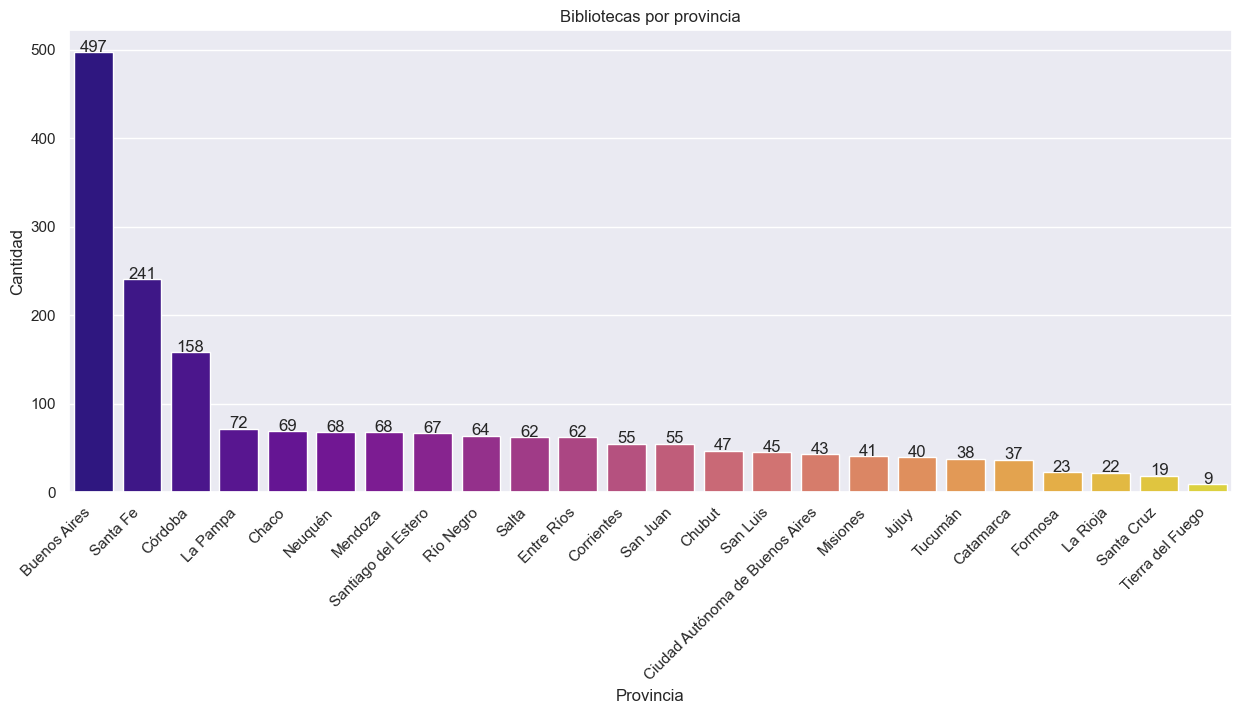

In [25]:
provincias = BP_limpio['provincia'].unique()

diccionario = {}
for provincia in provincias:
    diccionario[provincia] = len(BP_limpio.loc[BP_limpio['provincia'] == provincia])

# Creamos listas separadas para cada columna
provincias = list(diccionario.keys())
cantidad = list(diccionario.values())

# DataFrame con columnas
df = pd.DataFrame({
    'Provincia': provincias,
    'Cantidad': cantidad
})

df = df.sort_values(by='Cantidad', ascending=False) #ordeno las provincias por cantidad de bibliotecas de manera decreciente

sns.set(
    rc = {"figure.figsize": (15, 6)}
)  # Configuracion del ancho y largo del grafico para que se vea mejor

ax = sns.barplot(data=df, x='Provincia', y='Cantidad', palette='plasma') #grafico

plt.xticks(rotation=45, ha="right")  # Rotación y alineación del texto para que se puedan ver el nombre de cada una de las provincias

plt.title("Bibliotecas por provincia") # Titulo del grafico

for i, valor in enumerate(df["Cantidad"]):
    ax.text(i, valor + 0.5, str(valor), ha="center", fontsize=12)  # Usamos esto para poner el numero arriba de cada barra, asi es mas claro

plt.show()

#usamos la paleta plasma, ya que es amigable pora personas con daltonismo  (protanopia y deuteranopia)

# Segundo gráfico

"Graficar la cantidad de EE de los departamentos en función de la población,
separando por nivel educativo y su correspondiente grupo etario
(identificándolos por colores). Se pueden basar en la primera consulta SQL
para realizar este gráfico."

In [26]:
import plotly.graph_objects as go

df = pd.read_csv("ConsultasSQL\\Consulta_1.csv")                            # Cargamos los datos

df["chicos_por_jardin"] = df["poblacion_jardin"] / df["jardines"]           # Calculamos chicos por EE
df["chicos_por_primaria"] = df["poblacion_primaria"] / df["primarias"]
df["chicos_por_secundaria"] = df["poblacion_secundaria"] / df["secundarios"]

provincias = df["provincia"].unique()                                       # Listamos las provincias

colores = {
    "Jardín": "#E69F00",                                                # Colores para los niveles educativos
    "Primaria": "#56B4E9",
    "Secundaria": "#009E73"
}

fig = go.Figure()                                                           # Creamos figura con slider

for i, prov in enumerate(provincias):
    subdf = df[df["provincia"] == prov]
    departamentos = subdf["departamento"]

    # Agregar una barra para cada nivel
    for nivel, columna in zip(["Jardín", "Primaria", "Secundaria"],
                              ["chicos_por_jardin", "chicos_por_primaria", "chicos_por_secundaria"]):
        fig.add_trace(go.Bar(
            x=departamentos,
            y=subdf[columna],
            name=nivel,
            marker_color=colores[nivel],
            visible=(i == 0),  # solo la primera provincia visible por defecto
            offsetgroup=nivel,
            legendgroup=nivel,
            xaxis="x",
            yaxis="y"
        ))

steps = []                                                                  # Creamos los pasos del slider
for i, prov in enumerate(provincias):
    visibles = [False] * (len(provincias) * 3)
    for j in range(3):                                                      # cada provincia tiene 3 trazas
        visibles[i * 3 + j] = True
    step = dict(
        method="update",
        args=[{"visible": visibles},
              {"title": f"Provincia: {prov}"}],
        label=prov
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Provincia: "},
    pad={"t": 50},
    steps=steps
)]

# Layout final
fig.update_layout(                                                          # Layout final
    sliders=sliders,
    barmode='group',
    title="Cantidad de chicos por EE (Establecimientos Educativos)",
    xaxis_title="Departamento",
    yaxis_title="Chicos por EE",
    xaxis_tickangle=-45,
    height=600
)

fig.show()

# Tercer gráfico

"Realizar un boxplot por cada provincia, de la cantidad de EE por cada
departamento de la provincia. Mostrar todos los boxplots en una misma
figura, ordenados por la mediana de cada provincia."

C:\Users\Dell\AppData\Local\Temp\ipykernel_12968\1449059416.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Dell\AppData\Local\Temp\ipykernel_12968\1449059416.py:39: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




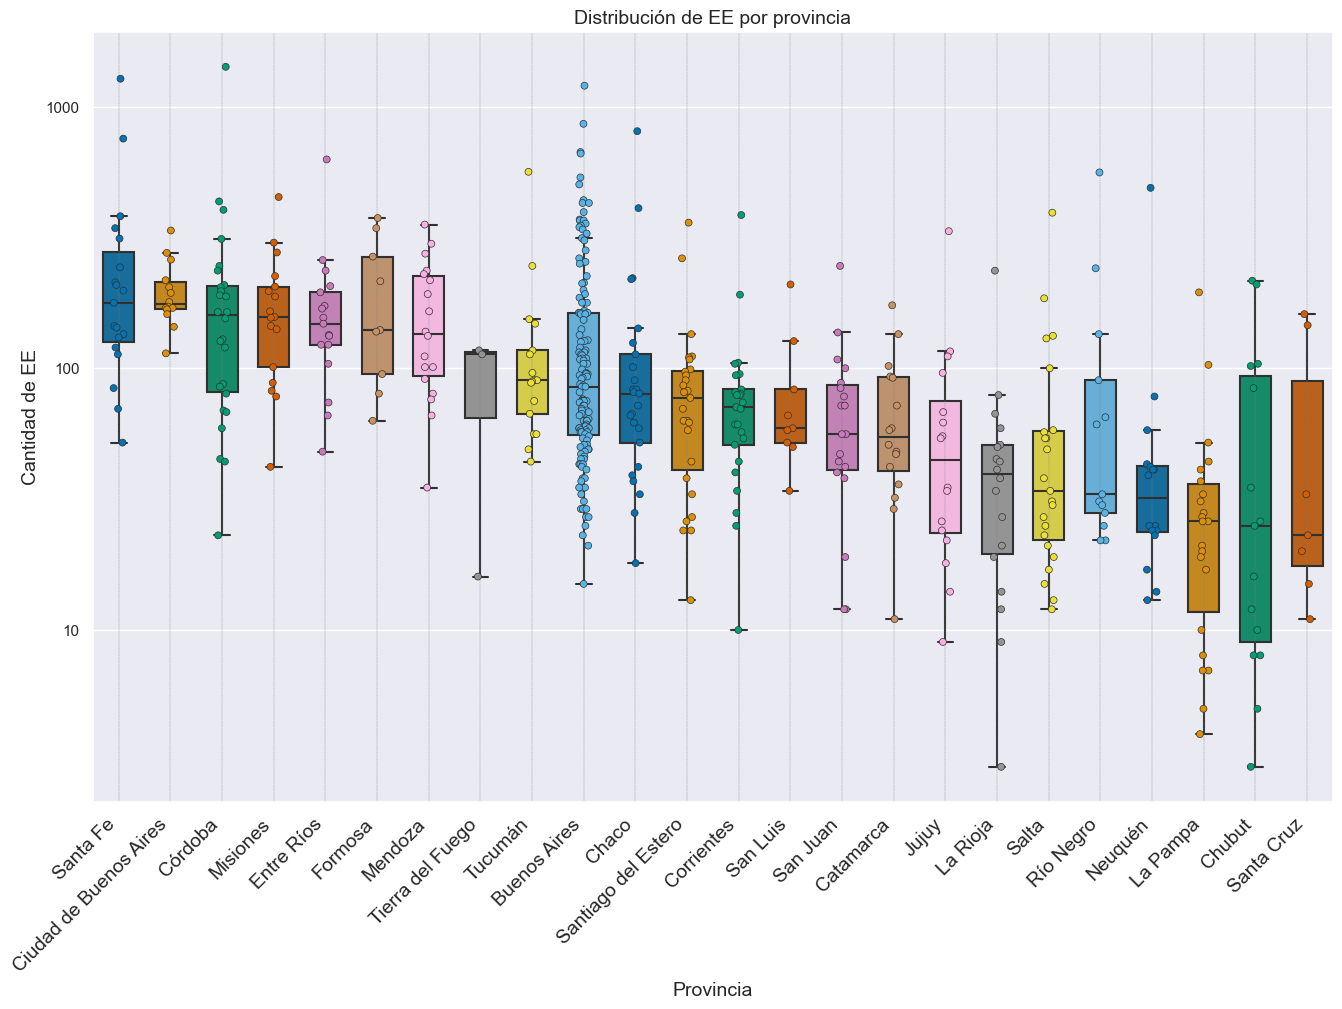

In [27]:
query = """
    SELECT EE_limpio01.Departamento, nombre AS provincia, COUNT(EE_limpio01.Departamento) AS cantidad 
    FROM EE_limpio01 JOIN  Departamento ON EE_limpio01."id_departamento" = Departamento."id_departamento"
    JOIN Provincia ON Departamento."id_provincia" = Provincia."id"
    GROUP BY EE_limpio01.Departamento, nombre
    ORDER BY cantidad DESC
"""

resultado = duckdb.query(query).df()

gr = pd.read_csv(r"Graficos\graf_3.csv") 



# #ordena por mediana de provincia, de manera descendiente
provincia_orden = (
    gr.groupby("provincia")["cantidad"]
    .median()
    .sort_values(ascending=False)
    .index
)

# #tamaño del grafico
plt.figure(figsize=(16,10))

# # --- Boxplot ---
boxplot = sns.boxplot(
    data=gr,
    x="provincia",
    y="cantidad",
    order=provincia_orden,
    palette="colorblind",
    width=0.6,
    showfliers=False,  # Ocultamos outliers (los mostramos con stripplot)
    linewidth=1.5
)

# # --- Stripplot ---
sns.stripplot(
    data=gr,
    x="provincia",
    y="cantidad",
    order=provincia_orden,    # Agrupar por provincia
    palette="colorblind",     # Misma paleta que boxplot
    dodge=False,           
    alpha=1,
    size=5,
    linewidth=0.5,
    legend=False           # Oculta leyenda duplicada
)

# # para la escala del eje y
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')


# # --- Ajustes finales ---
plt.title("Distribución de EE por provincia", fontsize=14)
plt.xlabel("Provincia", fontsize=14)
plt.ylabel("Cantidad de EE", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=14)

# #lineas para que se entiende a que provincia pertenece cada boxplot
for i in range(len(provincia_orden)):
    plt.axvline(i, color='gray', linewidth=0.3, linestyle='--')
    
plt.show()


# Cuarto gráfico

"Relación entre la cantidad de BP cada mil habitantes y de EE cada mil
habitantes por departamento."

In [28]:
import plotly.express as px

df = pd.read_csv("ConsultasSQL\\Consulta_3.csv")
df.columns = [col.strip().lower() for col in df.columns]

df["bp_por_mil"] = df["cantidad_bp"] / df["poblacion_total"] * 1000         # Calculamos valores por mil habitantes
df["ee_por_mil"] = df["cantidad_ee"] / df["poblacion_total"] * 1000

provincias = df["provincia"].unique()                           # Tomamos provincias únicas

color_palette = px.colors.qualitative.Safe                      # Paleta colorblind friendly

fig = go.Figure()                                               # Creamos figura
                                          
for i, prov in enumerate(provincias):                           # Agregamos trazas y regresiones por provincia
    datos = df[df["provincia"] == prov].copy()

    depto_codes = datos["departamento"].astype('category').cat.codes        # Asignamos color único por departamento (repitiendo la paleta si hace falta)
    colors = [color_palette[c % len(color_palette)] for c in depto_codes]

    fig.add_trace(go.Scatter(                                   # Scatter plot por provincia
        x=datos["bp_por_mil"],
        y=datos["ee_por_mil"],
        mode='markers',
        marker=dict(
            size=10,
            opacity=0.9,
            color=colors,
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        text=datos["departamento"],
        hovertemplate="<b>%{text}</b><br>BP/1000 hab: %{x:.2f}<br>EE/1000 hab: %{y:.2f}<extra></extra>",
        name=prov,
        visible=(i == 0),
        showlegend=False
    ))

    x = datos["bp_por_mil"]                                     # Agregamos regresión si es posible
    y = datos["ee_por_mil"]
    if len(x.dropna()) > 1 and x.nunique() > 1 and y.nunique() > 1:
        try:
            coef = np.polyfit(x, y, 1)
            poly1d_fn = np.poly1d(coef)
            x_sorted = np.linspace(x.min(), x.max(), 100)
            y_fit = poly1d_fn(x_sorted)

            fig.add_trace(go.Scatter(
                x=x_sorted,
                y=y_fit,
                mode="lines",
                line=dict(color="red", dash="dot"),
                name=f"Regresión - {prov}",
                visible=(i == 0),
                showlegend=False
            ))
        except np.linalg.LinAlgError:
            continue

steps = []
for i, prov in enumerate(provincias):                           # Creamos el slider
    vis = [False] * (2 * len(provincias))
    vis[i * 2] = True
    if i * 2 + 1 < len(vis):
        vis[i * 2 + 1] = True
    steps.append(dict(
        method="update",
        args=[{"visible": vis},
              {"title": f"Provincia: {prov}"}],
        label=prov
    ))

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Provincia: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(                                              # Layout
    sliders=sliders,
    xaxis_title="BP cada 1000 habitantes",
    yaxis_title="EE cada 1000 habitantes",
    title="Relación entre BP y EE por mil habitantes con regresión (paleta Safe)",
    height=650
)
fig.show()                                                      # Mostramos el gráfico